In [1]:
#Dataset
from utilsGAN import *
from keras.datasets.fashion_mnist import load_data

#Standatd libs
import matplotlib.pyplot as plt
import numpy as np
import time

#Model creation libs
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Embedding, Concatenate, BatchNormalization, ReLU
from keras.models import load_model
from keras.utils import plot_model

#CUDA libs
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

#Disable WARNING and INFO
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [127]:
#Add Gaussian noise to images
def add_noise(batch):
    noisy_batch = np.zeros(batch.shape)
    for i in range (len(batch)):
        image = batch[i]
        noise = np.random.normal(0,1,image.shape)
        noise = noise.reshape(image.shape)
        noisy_batch[i] = image + noise
        
    return noisy_batch

#Plot example images.
def show_examples(examples, labels, n, filename):
    fig, ax = plt.subplots(n,n, figsize = (50,50))
    for i in range (n):
        for j in range (n):
            ax[i,j].axis('off')
            ax[i,j].imshow(np.log(0.005 + examples[(n*i) + j, :, :, 0]), cmap = 'gray_r')
            if labels[(n*i) + j] == 0:
                ax[i,j].set_title('Non-Tidal')
            elif labels[(n*i) + j] == 0:
                ax[i,j].set_title('Shell')
            else:
                ax[i,j].set_title('Arm')
                
    plt.savefig('examples/grid_' + filename +'.png')

In [3]:
d, _ = data_categories()
len(d)

645

# 2 Conditional GAN

### 2.1 Model creation

In [3]:


#DISCRIMINATOR
def make_discriminator(input_shape = (256,256,1), nb_classes = 3):
    input_label = Input(shape = (1,))
    
    #Embed label 
    li = Embedding(nb_classes, 50)(input_label)
    
    #Scale up to image dimensions
    nb_nodes = input_shape[0] * input_shape[1]
    li = Dense(nb_nodes)(li)
    
    #Reshape as additional channel
    li = Reshape((input_shape[0], input_shape[1], 1))(li)
    
    #Merge embedded label with image
    input_image = Input(shape = input_shape)
    merge = Concatenate()([input_image, li])
    
    convargs = dict(kernel_size = (3,3), strides = (2,2), padding = 'same') 

    x = Conv2D(32, **convargs)(merge)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2D(64, **convargs)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2D(128, **convargs)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2D(256, **convargs)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2D(512, **convargs)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    
    output = Dense(1, activation = 'sigmoid')(x)
    model = Model([input_image, input_label], output)
    
    optimizer = Adam(lr = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model
    
#GENERATOR
def make_generator(latent_dim, nb_classes = 3):
    input_label = Input(shape = (1,))
    
    #Embed label
    li = Embedding(nb_classes, 50)(input_label)
    
    #Scale to low res image dimensions
    nb_nodes = 8*8
    li = Dense(nb_nodes)(li)
    
    #Reshape as additional channel 
    li = Reshape((8,8,1))(li)
    
    input_vector = Input(shape = (latent_dim,))
    
    #Foundation for low res images (128 7x7)
    nb_nodes = 8*8*512
    x = Dense(nb_nodes)(input_vector)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Reshape((8,8,512))(x)
    
    #Merge embedded label with low res images
    merge = Concatenate()([x, li])
    
    convargs = dict(kernel_size = (3,3), strides = (2,2), padding = 'same') 
    
    x = Conv2DTranspose(512, **convargs)(merge)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2DTranspose(256, **convargs)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2DTranspose(128, **convargs)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2DTranspose(64, **convargs)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = Conv2DTranspose(32, **convargs)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    output = Conv2D(1, (7,7), activation = 'tanh', padding = 'same')(x)
    model = Model([input_vector, input_label], output)
    
    return model

#C-GAN
def make_gan(g_model, d_model):
    #Freeze discriminator weights.
    d_model.trainable = False
    
    #Get generator inputs
    g_noise, g_label = g_model.input
    
    #Get generator output
    g_output = g_model.output
    
    #Connect both parts
    gan_output = d_model([g_output, g_label])
    model = Model([g_noise, g_label], gan_output)
    
    optimizer = Adam(lr = 0.0002, beta_1 = 0.5)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    
    return model
    

In [4]:
#LOAD AND SCALE DATA
def load_real_samples():
    images, labels = data_categories()#test_data('threshold_3sig')
    
    #Add colour dimension
    X = images.astype('float32')
    
    #Scale from [0,1] to [-1,1]
    X = (X*2) - 1
    
    return [X, labels]

#GENERATE REAL IMAGE BATCH
def generate_real_batch(dataset, nb_samples):
    images, labels = dataset
    
    ix = np.random.randint(0, images.shape[0], nb_samples)
    X, train_labels = images[ix], labels[ix]
    
    #Remove used
    new_data = []
    new_labels = []
    for i in range (len(images)):
        if i not in ix:
            new_data.append(images[i])
            new_labels.append(labels[i])
            
    dataset = [np.array(new_data), np.array(new_labels)]
    
    #Add noise
    #X = add_noise(X)
    
    #Get class label (1 = real image)
    y = np.ones((nb_samples, 1))
    
    return [X, train_labels], y, dataset

#SAMPLE LATENS SPACE FOR GENERATOR INPUT
def generate_latent_points(latent_dim, nb_samples, nb_classes = 2):
    x_input = np.random.randn(latent_dim * nb_samples)
    labels = np.random.randint(0, nb_classes, nb_samples)
    
    #Reshep into input shape batch
    z_input = x_input.reshape(nb_samples, latent_dim)
    
    return [z_input, labels]

#GENERATE FAKE IMAGE BATCH
def generate_fake_batch(generator, latent_dim, nb_samples):
    z_input, labels_input = generate_latent_points(latent_dim, nb_samples)
    
    #Get fake images
    images = generator.predict([z_input, labels_input])
    
    #Add noise
    #images = add_noise(images)
    
    #Get class label (0 = fake/generated images)
    y = np.zeros((nb_samples, 1))
    
    return [images, labels_input], y

def test_confidence(generator, latent_dim):
    z_input, _ = generate_latent_points(latent_dim, 10)
    labels = np.ones((10,1))
    
    X = generator.predict([z_input, labels])
    X = (X + 1)/2.0
    
    pred1 = model1.predict(X)
    pred2 = model2.predict(X)
    pred3 = model3.predict(X)
    pred4 = model4.predict(X)
    pred5 = model5.predict(X)
    
    predictions = np.concatenate((pred1, pred2, pred3, pred4, pred5), axis = 0)
    mean_pred = np.mean(predictions, axis = 0)
    conf = np.mean(mean_pred)
    
    return conf

In [5]:
#TRAIN GAN
def train(g_model, d_model, gan_model, dataset, latent_dim, nb_epochs, batch_size):
    half_batch = int(batch_size/2)
    
    epochs = []
    d1_record = []
    d2_record = []
    g_record = []
    conf_record = []
    
    full_data = np.copy(dataset[0])
    full_labels = np.copy(dataset[1])
    
    #Manually enumerate epochs
    for i in range (nb_epochs):
        start = time.time()
        
        #Refill training data
        dataset = [full_data, full_labels]
        
        #Train over whole training data
        while len(dataset[0]) >= half_batch:

            #Get real samples
            [X_real, labels_real], y_real, dataset = generate_real_batch(dataset, half_batch)
            
            #Update discriminator weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
            #Get fake samples
            [X_fake, labels_fake], y_fake = generate_fake_batch(g_model, latent_dim, half_batch)
            
            #Update discriminator weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels_fake], y_fake)
            
            #Get latent points (generator input) and 'false' labels
            [z_inputs, labels_inputs] = generate_latent_points(latent_dim, batch_size)
            y_gan = np.ones((batch_size, 1))
            
            #Update generator (via discriminator error)
            g_loss = gan_model.train_on_batch([z_inputs, labels_inputs], y_gan)
           
        end = time.time() - start
        #Display epoch loss
        print('Epoch %d/%d, %.1f sec, d1=%.3f, d2=%.3f, g=%.3f' % (i+1, nb_epochs, end, d_loss1, d_loss2, g_loss))
        
        #Record metrics
        epochs.append(i+1)
        d1_record.append(d_loss1)
        d2_record.append(d_loss2)
        g_record.append(g_loss)
        
        #Save generator every 10 epochs
        if (i+1) % 100 == 0:
            g_model.save('models_test/gan_generator_' + str(i+1) +'.h5')
            print('Model saved!')
        
    return epochs, [d1_record, d2_record, g_record, conf_record]

In [6]:
nb_epochs = 3000
batch_size = 64
latent_dim = 100

discriminator = make_discriminator()
generator = make_generator(latent_dim)
gan_model = make_gan(generator, discriminator)

dataset = load_real_samples()

epochs, metrics = train(generator, discriminator, gan_model, dataset, latent_dim, nb_epochs, batch_size)

Epoch 1/3000, 24.8 sec, d1=0.619, d2=0.776, g=0.725
Epoch 2/3000, 18.0 sec, d1=0.690, d2=0.674, g=0.755
Epoch 3/3000, 18.0 sec, d1=0.625, d2=0.626, g=0.803
Epoch 4/3000, 18.0 sec, d1=0.452, d2=0.527, g=1.632
Epoch 5/3000, 18.0 sec, d1=0.285, d2=0.308, g=1.592
Epoch 6/3000, 18.0 sec, d1=0.691, d2=0.574, g=1.150
Epoch 7/3000, 18.0 sec, d1=0.559, d2=0.527, g=1.135
Epoch 8/3000, 18.1 sec, d1=0.798, d2=0.731, g=1.078
Epoch 9/3000, 18.0 sec, d1=0.599, d2=0.645, g=0.894
Epoch 10/3000, 18.1 sec, d1=0.620, d2=0.607, g=0.888
Epoch 11/3000, 18.1 sec, d1=0.602, d2=0.566, g=0.903
Epoch 12/3000, 18.1 sec, d1=0.662, d2=0.552, g=0.899
Epoch 13/3000, 18.1 sec, d1=0.634, d2=0.553, g=0.929
Epoch 14/3000, 18.1 sec, d1=0.672, d2=0.540, g=0.893
Epoch 15/3000, 18.1 sec, d1=0.610, d2=0.543, g=0.913
Epoch 16/3000, 18.1 sec, d1=0.573, d2=0.522, g=0.925
Epoch 17/3000, 18.1 sec, d1=0.611, d2=0.531, g=0.905
Epoch 18/3000, 18.1 sec, d1=0.596, d2=0.523, g=0.927
Epoch 19/3000, 18.0 sec, d1=0.595, d2=0.537, g=0.912
Ep

Epoch 155/3000, 18.1 sec, d1=0.177, d2=0.462, g=1.177
Epoch 156/3000, 18.0 sec, d1=0.481, d2=0.466, g=1.157
Epoch 157/3000, 18.0 sec, d1=0.511, d2=0.423, g=1.093
Epoch 158/3000, 18.1 sec, d1=0.496, d2=0.444, g=1.123
Epoch 159/3000, 18.0 sec, d1=0.656, d2=0.444, g=1.101
Epoch 160/3000, 18.0 sec, d1=0.508, d2=0.426, g=1.090
Epoch 161/3000, 18.0 sec, d1=0.662, d2=0.415, g=1.100
Epoch 162/3000, 18.0 sec, d1=0.333, d2=0.577, g=1.062
Epoch 163/3000, 18.0 sec, d1=0.402, d2=0.402, g=1.200
Epoch 164/3000, 18.0 sec, d1=0.609, d2=0.455, g=1.112
Epoch 165/3000, 18.1 sec, d1=0.238, d2=0.446, g=1.220
Epoch 166/3000, 18.0 sec, d1=0.570, d2=0.444, g=1.092
Epoch 167/3000, 18.2 sec, d1=0.505, d2=0.420, g=1.194
Epoch 168/3000, 18.1 sec, d1=0.688, d2=0.487, g=1.097
Epoch 169/3000, 18.0 sec, d1=0.834, d2=0.449, g=1.149
Epoch 170/3000, 18.1 sec, d1=0.734, d2=0.496, g=1.089
Epoch 171/3000, 18.1 sec, d1=0.456, d2=0.432, g=1.175
Epoch 172/3000, 18.1 sec, d1=0.363, d2=0.493, g=1.390
Epoch 173/3000, 18.1 sec, d1

Epoch 307/3000, 18.1 sec, d1=0.372, d2=0.282, g=1.790
Epoch 308/3000, 18.1 sec, d1=0.378, d2=0.301, g=2.035
Epoch 309/3000, 18.0 sec, d1=0.254, d2=0.186, g=2.099
Epoch 310/3000, 18.1 sec, d1=0.384, d2=0.259, g=1.853
Epoch 311/3000, 18.1 sec, d1=0.119, d2=0.195, g=2.205
Epoch 312/3000, 18.1 sec, d1=0.255, d2=0.161, g=2.213
Epoch 313/3000, 18.1 sec, d1=0.267, d2=0.206, g=2.153
Epoch 314/3000, 18.1 sec, d1=0.180, d2=0.222, g=2.118
Epoch 315/3000, 18.1 sec, d1=0.210, d2=0.193, g=2.270
Epoch 316/3000, 18.0 sec, d1=0.365, d2=0.197, g=2.518
Epoch 317/3000, 18.1 sec, d1=0.140, d2=0.250, g=1.919
Epoch 318/3000, 18.1 sec, d1=0.297, d2=0.207, g=2.218
Epoch 319/3000, 18.1 sec, d1=0.482, d2=0.158, g=2.547
Epoch 320/3000, 18.0 sec, d1=0.529, d2=0.368, g=2.165
Epoch 321/3000, 18.1 sec, d1=0.547, d2=0.286, g=1.975
Epoch 322/3000, 18.0 sec, d1=0.427, d2=0.283, g=2.317
Epoch 323/3000, 18.1 sec, d1=0.381, d2=0.201, g=2.350
Epoch 324/3000, 18.1 sec, d1=0.239, d2=0.228, g=2.059
Epoch 325/3000, 18.1 sec, d1

Epoch 459/3000, 18.1 sec, d1=0.115, d2=0.231, g=2.788
Epoch 460/3000, 18.1 sec, d1=0.345, d2=0.301, g=2.243
Epoch 461/3000, 18.0 sec, d1=0.318, d2=0.234, g=2.495
Epoch 462/3000, 18.1 sec, d1=0.519, d2=0.159, g=2.650
Epoch 463/3000, 18.1 sec, d1=0.281, d2=0.162, g=2.748
Epoch 464/3000, 18.0 sec, d1=0.279, d2=0.224, g=2.752
Epoch 465/3000, 18.0 sec, d1=0.435, d2=0.170, g=2.327
Epoch 466/3000, 18.0 sec, d1=0.203, d2=0.219, g=2.439
Epoch 467/3000, 18.0 sec, d1=0.334, d2=0.269, g=3.237
Epoch 468/3000, 18.0 sec, d1=0.169, d2=0.312, g=2.915
Epoch 469/3000, 18.0 sec, d1=0.260, d2=0.154, g=2.916
Epoch 470/3000, 18.1 sec, d1=0.614, d2=0.222, g=2.146
Epoch 471/3000, 18.0 sec, d1=0.395, d2=0.206, g=2.538
Epoch 472/3000, 18.0 sec, d1=0.140, d2=0.324, g=3.051
Epoch 473/3000, 18.1 sec, d1=0.138, d2=0.151, g=3.102
Epoch 474/3000, 18.0 sec, d1=0.204, d2=0.207, g=2.596
Epoch 475/3000, 18.1 sec, d1=0.405, d2=0.155, g=3.043
Epoch 476/3000, 18.0 sec, d1=0.264, d2=0.302, g=2.590
Epoch 477/3000, 18.1 sec, d1

Epoch 611/3000, 18.1 sec, d1=0.656, d2=0.168, g=3.159
Epoch 612/3000, 18.0 sec, d1=0.674, d2=0.227, g=2.939
Epoch 613/3000, 18.0 sec, d1=0.283, d2=0.202, g=2.540
Epoch 614/3000, 18.0 sec, d1=0.271, d2=0.245, g=2.744
Epoch 615/3000, 18.0 sec, d1=0.406, d2=0.243, g=2.773
Epoch 616/3000, 18.1 sec, d1=0.612, d2=0.304, g=2.702
Epoch 617/3000, 18.0 sec, d1=0.373, d2=0.134, g=2.473
Epoch 618/3000, 18.0 sec, d1=0.406, d2=0.166, g=2.953
Epoch 619/3000, 18.0 sec, d1=0.086, d2=0.229, g=2.983
Epoch 620/3000, 18.1 sec, d1=0.462, d2=0.216, g=2.522
Epoch 621/3000, 18.1 sec, d1=0.162, d2=0.174, g=3.469
Epoch 622/3000, 18.1 sec, d1=0.661, d2=0.200, g=2.918
Epoch 623/3000, 18.1 sec, d1=0.132, d2=0.306, g=2.604
Epoch 624/3000, 18.1 sec, d1=0.232, d2=0.194, g=3.145
Epoch 625/3000, 18.0 sec, d1=0.298, d2=0.141, g=2.400
Epoch 626/3000, 18.0 sec, d1=0.210, d2=0.225, g=2.710
Epoch 627/3000, 18.0 sec, d1=0.099, d2=0.081, g=2.791
Epoch 628/3000, 18.0 sec, d1=0.356, d2=0.232, g=2.553
Epoch 629/3000, 18.1 sec, d1

Epoch 763/3000, 18.2 sec, d1=0.311, d2=0.204, g=2.332
Epoch 764/3000, 18.1 sec, d1=0.232, d2=0.300, g=3.028
Epoch 765/3000, 18.0 sec, d1=0.474, d2=0.171, g=2.784
Epoch 766/3000, 18.0 sec, d1=0.498, d2=0.198, g=2.940
Epoch 767/3000, 18.0 sec, d1=0.264, d2=0.195, g=2.589
Epoch 768/3000, 18.0 sec, d1=0.141, d2=0.129, g=3.208
Epoch 769/3000, 18.1 sec, d1=0.220, d2=0.152, g=2.919
Epoch 770/3000, 18.0 sec, d1=0.351, d2=0.216, g=2.544
Epoch 771/3000, 18.0 sec, d1=0.293, d2=0.127, g=3.051
Epoch 772/3000, 18.0 sec, d1=0.189, d2=0.164, g=2.847
Epoch 773/3000, 18.0 sec, d1=0.415, d2=0.172, g=3.008
Epoch 774/3000, 18.0 sec, d1=0.437, d2=0.127, g=3.158
Epoch 775/3000, 18.0 sec, d1=0.326, d2=0.167, g=2.405
Epoch 776/3000, 18.1 sec, d1=0.355, d2=0.133, g=2.893
Epoch 777/3000, 18.0 sec, d1=0.275, d2=0.269, g=2.194
Epoch 778/3000, 18.0 sec, d1=0.202, d2=0.186, g=2.976
Epoch 779/3000, 18.0 sec, d1=0.186, d2=0.166, g=2.997
Epoch 780/3000, 18.1 sec, d1=0.418, d2=0.103, g=3.061
Epoch 781/3000, 18.0 sec, d1

Epoch 915/3000, 18.0 sec, d1=0.297, d2=0.149, g=2.479
Epoch 916/3000, 18.0 sec, d1=0.180, d2=0.166, g=2.627
Epoch 917/3000, 18.0 sec, d1=0.130, d2=0.160, g=2.942
Epoch 918/3000, 18.0 sec, d1=0.202, d2=0.253, g=2.707
Epoch 919/3000, 18.2 sec, d1=0.409, d2=0.224, g=2.260
Epoch 920/3000, 18.1 sec, d1=0.168, d2=0.202, g=2.783
Epoch 921/3000, 18.0 sec, d1=0.272, d2=0.121, g=2.831
Epoch 922/3000, 18.1 sec, d1=0.421, d2=0.220, g=2.212
Epoch 923/3000, 18.1 sec, d1=0.523, d2=0.083, g=3.199
Epoch 924/3000, 18.1 sec, d1=0.364, d2=0.241, g=3.486
Epoch 925/3000, 18.0 sec, d1=0.684, d2=0.189, g=2.525
Epoch 926/3000, 18.0 sec, d1=0.477, d2=0.228, g=2.286
Epoch 927/3000, 18.0 sec, d1=0.415, d2=0.207, g=2.957
Epoch 928/3000, 18.1 sec, d1=0.327, d2=0.281, g=2.772
Epoch 929/3000, 18.0 sec, d1=0.578, d2=0.137, g=2.558
Epoch 930/3000, 18.0 sec, d1=0.098, d2=0.278, g=2.922
Epoch 931/3000, 18.1 sec, d1=0.363, d2=0.213, g=2.953
Epoch 932/3000, 18.0 sec, d1=0.362, d2=0.225, g=2.799
Epoch 933/3000, 18.0 sec, d1

Epoch 1066/3000, 18.0 sec, d1=1.090, d2=0.138, g=2.721
Epoch 1067/3000, 18.0 sec, d1=0.168, d2=0.185, g=2.747
Epoch 1068/3000, 18.0 sec, d1=0.165, d2=0.091, g=3.531
Epoch 1069/3000, 18.2 sec, d1=0.038, d2=0.191, g=3.158
Epoch 1070/3000, 18.0 sec, d1=0.260, d2=0.299, g=2.932
Epoch 1071/3000, 18.1 sec, d1=0.160, d2=0.106, g=2.899
Epoch 1072/3000, 18.1 sec, d1=0.651, d2=0.297, g=2.834
Epoch 1073/3000, 18.1 sec, d1=0.342, d2=0.097, g=2.735
Epoch 1074/3000, 18.9 sec, d1=0.399, d2=0.230, g=2.531
Epoch 1075/3000, 18.1 sec, d1=0.189, d2=0.269, g=2.741
Epoch 1076/3000, 18.1 sec, d1=0.208, d2=0.167, g=3.189
Epoch 1077/3000, 18.1 sec, d1=0.507, d2=0.139, g=2.425
Epoch 1078/3000, 18.1 sec, d1=0.313, d2=0.195, g=2.760
Epoch 1079/3000, 18.1 sec, d1=0.328, d2=0.206, g=2.444
Epoch 1080/3000, 18.1 sec, d1=0.319, d2=0.186, g=2.753
Epoch 1081/3000, 18.1 sec, d1=0.430, d2=0.125, g=2.594
Epoch 1082/3000, 18.1 sec, d1=0.438, d2=0.130, g=2.202
Epoch 1083/3000, 18.1 sec, d1=0.149, d2=0.142, g=2.746
Epoch 1084

Epoch 1215/3000, 18.0 sec, d1=0.283, d2=0.381, g=2.388
Epoch 1216/3000, 18.0 sec, d1=0.287, d2=0.167, g=2.795
Epoch 1217/3000, 17.2 sec, d1=0.194, d2=0.233, g=3.151
Epoch 1218/3000, 18.1 sec, d1=0.104, d2=0.258, g=2.838
Epoch 1219/3000, 18.0 sec, d1=0.089, d2=0.088, g=3.212
Epoch 1220/3000, 18.1 sec, d1=0.605, d2=0.191, g=3.430
Epoch 1221/3000, 18.1 sec, d1=0.376, d2=0.099, g=3.073
Epoch 1222/3000, 18.1 sec, d1=0.299, d2=0.256, g=2.912
Epoch 1223/3000, 18.1 sec, d1=0.137, d2=0.215, g=2.893
Epoch 1224/3000, 18.1 sec, d1=0.407, d2=0.164, g=2.921
Epoch 1225/3000, 18.0 sec, d1=0.248, d2=0.234, g=2.763
Epoch 1226/3000, 18.1 sec, d1=0.314, d2=0.133, g=2.604
Epoch 1227/3000, 18.1 sec, d1=0.218, d2=0.146, g=2.717
Epoch 1228/3000, 18.1 sec, d1=0.185, d2=0.129, g=3.196
Epoch 1229/3000, 18.0 sec, d1=0.209, d2=0.209, g=2.560
Epoch 1230/3000, 18.0 sec, d1=0.186, d2=0.166, g=3.193
Epoch 1231/3000, 18.0 sec, d1=0.308, d2=0.239, g=2.850
Epoch 1232/3000, 18.0 sec, d1=0.779, d2=0.169, g=2.797
Epoch 1233

Epoch 1364/3000, 18.0 sec, d1=0.397, d2=0.199, g=3.507
Epoch 1365/3000, 18.0 sec, d1=0.375, d2=0.168, g=2.267
Epoch 1366/3000, 18.0 sec, d1=0.134, d2=0.099, g=3.147
Epoch 1367/3000, 18.1 sec, d1=0.207, d2=0.210, g=2.693
Epoch 1368/3000, 18.0 sec, d1=0.512, d2=0.182, g=3.161
Epoch 1369/3000, 18.0 sec, d1=0.448, d2=0.313, g=2.739
Epoch 1370/3000, 18.0 sec, d1=0.233, d2=0.174, g=2.741
Epoch 1371/3000, 18.2 sec, d1=0.349, d2=0.242, g=2.661
Epoch 1372/3000, 18.1 sec, d1=0.497, d2=0.199, g=3.317
Epoch 1373/3000, 18.1 sec, d1=0.295, d2=0.251, g=2.472
Epoch 1374/3000, 18.1 sec, d1=0.306, d2=0.185, g=2.353
Epoch 1375/3000, 18.1 sec, d1=0.337, d2=0.173, g=2.959
Epoch 1376/3000, 18.0 sec, d1=0.233, d2=0.105, g=3.395
Epoch 1377/3000, 18.1 sec, d1=0.216, d2=0.275, g=2.701
Epoch 1378/3000, 18.0 sec, d1=0.649, d2=0.255, g=3.174
Epoch 1379/3000, 18.1 sec, d1=0.148, d2=0.135, g=3.631
Epoch 1380/3000, 18.1 sec, d1=0.226, d2=0.226, g=2.792
Epoch 1381/3000, 18.1 sec, d1=0.270, d2=0.117, g=3.148
Epoch 1382

Epoch 1513/3000, 18.1 sec, d1=0.493, d2=0.226, g=2.955
Epoch 1514/3000, 18.1 sec, d1=0.180, d2=0.161, g=2.922
Epoch 1515/3000, 18.0 sec, d1=0.342, d2=0.259, g=2.625
Epoch 1516/3000, 18.1 sec, d1=0.527, d2=0.078, g=3.488
Epoch 1517/3000, 18.0 sec, d1=0.132, d2=0.159, g=3.254
Epoch 1518/3000, 18.0 sec, d1=0.441, d2=0.130, g=3.080
Epoch 1519/3000, 18.0 sec, d1=0.160, d2=0.246, g=3.285
Epoch 1520/3000, 18.1 sec, d1=0.290, d2=0.201, g=2.960
Epoch 1521/3000, 18.9 sec, d1=0.330, d2=0.185, g=2.900
Epoch 1522/3000, 18.1 sec, d1=0.030, d2=0.113, g=3.234
Epoch 1523/3000, 18.1 sec, d1=0.094, d2=0.101, g=2.923
Epoch 1524/3000, 18.1 sec, d1=0.174, d2=0.201, g=3.576
Epoch 1525/3000, 18.0 sec, d1=0.098, d2=0.202, g=2.824
Epoch 1526/3000, 18.1 sec, d1=0.229, d2=0.146, g=2.732
Epoch 1527/3000, 18.1 sec, d1=0.305, d2=0.167, g=3.310
Epoch 1528/3000, 18.1 sec, d1=0.287, d2=0.159, g=2.745
Epoch 1529/3000, 18.1 sec, d1=0.079, d2=0.158, g=2.961
Epoch 1530/3000, 18.1 sec, d1=0.126, d2=0.146, g=3.263
Epoch 1531

Epoch 1662/3000, 18.1 sec, d1=0.057, d2=0.064, g=3.793
Epoch 1663/3000, 18.0 sec, d1=0.124, d2=0.198, g=3.090
Epoch 1664/3000, 18.1 sec, d1=0.086, d2=0.117, g=3.241
Epoch 1665/3000, 18.0 sec, d1=0.405, d2=0.164, g=3.388
Epoch 1666/3000, 18.1 sec, d1=0.331, d2=0.149, g=3.171
Epoch 1667/3000, 18.0 sec, d1=0.092, d2=0.196, g=4.030
Epoch 1668/3000, 18.0 sec, d1=0.553, d2=0.228, g=3.520
Epoch 1669/3000, 17.9 sec, d1=0.117, d2=0.136, g=3.477
Epoch 1670/3000, 18.0 sec, d1=0.053, d2=0.140, g=3.272
Epoch 1671/3000, 18.0 sec, d1=0.181, d2=0.100, g=3.045
Epoch 1672/3000, 18.0 sec, d1=0.315, d2=0.165, g=2.888
Epoch 1673/3000, 18.0 sec, d1=0.424, d2=0.174, g=3.031
Epoch 1674/3000, 18.0 sec, d1=0.311, d2=0.137, g=3.275
Epoch 1675/3000, 18.0 sec, d1=0.091, d2=0.173, g=3.327
Epoch 1676/3000, 18.0 sec, d1=0.046, d2=0.098, g=3.079
Epoch 1677/3000, 18.0 sec, d1=0.277, d2=0.209, g=3.617
Epoch 1678/3000, 18.0 sec, d1=0.548, d2=0.163, g=2.582
Epoch 1679/3000, 18.0 sec, d1=0.264, d2=0.237, g=2.562
Epoch 1680

Epoch 1811/3000, 18.1 sec, d1=0.283, d2=0.175, g=3.100
Epoch 1812/3000, 18.1 sec, d1=0.468, d2=0.209, g=2.949
Epoch 1813/3000, 18.1 sec, d1=0.092, d2=0.132, g=3.419
Epoch 1814/3000, 18.1 sec, d1=0.379, d2=0.205, g=3.272
Epoch 1815/3000, 18.1 sec, d1=0.077, d2=0.092, g=3.434
Epoch 1816/3000, 18.1 sec, d1=0.163, d2=0.101, g=3.731
Epoch 1817/3000, 18.1 sec, d1=0.132, d2=0.225, g=3.198
Epoch 1818/3000, 18.1 sec, d1=0.147, d2=0.136, g=3.152
Epoch 1819/3000, 18.1 sec, d1=0.142, d2=0.155, g=3.518
Epoch 1820/3000, 18.1 sec, d1=0.178, d2=0.219, g=3.039
Epoch 1821/3000, 18.1 sec, d1=0.105, d2=0.115, g=3.539
Epoch 1822/3000, 18.1 sec, d1=0.336, d2=0.282, g=3.052
Epoch 1823/3000, 18.1 sec, d1=0.101, d2=0.173, g=3.472
Epoch 1824/3000, 18.1 sec, d1=0.436, d2=0.178, g=3.645
Epoch 1825/3000, 18.1 sec, d1=0.329, d2=0.107, g=2.998
Epoch 1826/3000, 18.1 sec, d1=0.037, d2=0.167, g=3.222
Epoch 1827/3000, 18.1 sec, d1=0.354, d2=0.104, g=3.137
Epoch 1828/3000, 18.1 sec, d1=0.434, d2=0.133, g=3.423
Epoch 1829

Epoch 1960/3000, 18.1 sec, d1=0.153, d2=0.116, g=3.274
Epoch 1961/3000, 18.1 sec, d1=0.071, d2=0.118, g=3.501
Epoch 1962/3000, 18.1 sec, d1=0.408, d2=0.103, g=3.413
Epoch 1963/3000, 18.2 sec, d1=0.240, d2=0.170, g=3.013
Epoch 1964/3000, 18.1 sec, d1=0.258, d2=0.166, g=3.639
Epoch 1965/3000, 18.1 sec, d1=0.124, d2=0.139, g=3.344
Epoch 1966/3000, 18.1 sec, d1=0.128, d2=0.144, g=3.183
Epoch 1967/3000, 18.0 sec, d1=0.421, d2=0.088, g=3.957
Epoch 1968/3000, 18.0 sec, d1=0.556, d2=0.198, g=2.887
Epoch 1969/3000, 18.1 sec, d1=0.287, d2=0.155, g=3.189
Epoch 1970/3000, 18.0 sec, d1=0.397, d2=0.295, g=3.136
Epoch 1971/3000, 18.1 sec, d1=0.138, d2=0.151, g=3.185
Epoch 1972/3000, 18.0 sec, d1=0.606, d2=0.115, g=3.650
Epoch 1973/3000, 18.0 sec, d1=0.225, d2=0.143, g=3.357
Epoch 1974/3000, 18.0 sec, d1=0.039, d2=0.208, g=3.652
Epoch 1975/3000, 18.0 sec, d1=0.189, d2=0.145, g=3.594
Epoch 1976/3000, 18.9 sec, d1=0.431, d2=0.109, g=3.041
Epoch 1977/3000, 18.0 sec, d1=0.113, d2=0.123, g=3.434
Epoch 1978

Epoch 2109/3000, 18.1 sec, d1=0.085, d2=0.214, g=3.637
Epoch 2110/3000, 18.1 sec, d1=0.181, d2=0.119, g=3.576
Epoch 2111/3000, 18.1 sec, d1=0.475, d2=0.227, g=3.535
Epoch 2112/3000, 18.0 sec, d1=0.317, d2=0.093, g=3.242
Epoch 2113/3000, 18.0 sec, d1=0.098, d2=0.082, g=3.544
Epoch 2114/3000, 18.0 sec, d1=0.327, d2=0.226, g=3.176
Epoch 2115/3000, 18.0 sec, d1=0.646, d2=0.159, g=3.505
Epoch 2116/3000, 18.0 sec, d1=0.741, d2=0.181, g=4.129
Epoch 2117/3000, 18.1 sec, d1=0.252, d2=0.173, g=3.251
Epoch 2118/3000, 18.0 sec, d1=0.413, d2=0.091, g=3.706
Epoch 2119/3000, 18.0 sec, d1=0.609, d2=0.132, g=3.335
Epoch 2120/3000, 18.2 sec, d1=0.178, d2=0.220, g=3.504
Epoch 2121/3000, 18.1 sec, d1=0.375, d2=0.222, g=2.774
Epoch 2122/3000, 18.1 sec, d1=0.322, d2=0.125, g=3.925
Epoch 2123/3000, 18.1 sec, d1=0.100, d2=0.244, g=3.429
Epoch 2124/3000, 18.1 sec, d1=0.267, d2=0.195, g=3.694
Epoch 2125/3000, 18.0 sec, d1=0.391, d2=0.101, g=3.474
Epoch 2126/3000, 18.0 sec, d1=0.188, d2=0.130, g=3.728
Epoch 2127

Epoch 2258/3000, 18.6 sec, d1=0.188, d2=0.137, g=2.883
Epoch 2259/3000, 18.2 sec, d1=0.318, d2=0.199, g=3.158
Epoch 2260/3000, 18.2 sec, d1=0.120, d2=0.087, g=3.562
Epoch 2261/3000, 18.2 sec, d1=0.439, d2=0.336, g=3.072
Epoch 2262/3000, 18.2 sec, d1=0.277, d2=0.127, g=3.753
Epoch 2263/3000, 18.2 sec, d1=0.270, d2=0.099, g=2.935
Epoch 2264/3000, 18.2 sec, d1=0.216, d2=0.067, g=3.715
Epoch 2265/3000, 18.2 sec, d1=0.280, d2=0.234, g=2.962
Epoch 2266/3000, 18.2 sec, d1=0.188, d2=0.116, g=3.289
Epoch 2267/3000, 18.2 sec, d1=0.758, d2=0.247, g=3.239
Epoch 2268/3000, 18.2 sec, d1=0.277, d2=0.144, g=3.582
Epoch 2269/3000, 18.2 sec, d1=0.518, d2=0.101, g=3.732
Epoch 2270/3000, 18.3 sec, d1=0.265, d2=0.217, g=3.539
Epoch 2271/3000, 18.2 sec, d1=0.169, d2=0.097, g=3.446
Epoch 2272/3000, 18.1 sec, d1=0.103, d2=0.167, g=3.868
Epoch 2273/3000, 18.2 sec, d1=0.257, d2=0.130, g=3.369
Epoch 2274/3000, 18.2 sec, d1=0.558, d2=0.165, g=3.495
Epoch 2275/3000, 18.1 sec, d1=0.072, d2=0.090, g=3.792
Epoch 2276

Epoch 2407/3000, 18.1 sec, d1=0.345, d2=0.166, g=3.475
Epoch 2408/3000, 18.1 sec, d1=0.204, d2=0.152, g=3.533
Epoch 2409/3000, 18.1 sec, d1=0.064, d2=0.096, g=3.067
Epoch 2410/3000, 18.1 sec, d1=0.829, d2=0.049, g=4.328
Epoch 2411/3000, 18.1 sec, d1=0.411, d2=0.166, g=3.497
Epoch 2412/3000, 18.1 sec, d1=0.169, d2=0.115, g=4.392
Epoch 2413/3000, 18.1 sec, d1=0.387, d2=0.523, g=3.283
Epoch 2414/3000, 18.1 sec, d1=0.100, d2=0.087, g=3.396
Epoch 2415/3000, 18.1 sec, d1=0.176, d2=0.140, g=3.260
Epoch 2416/3000, 18.1 sec, d1=0.083, d2=0.107, g=3.467
Epoch 2417/3000, 18.1 sec, d1=0.315, d2=0.107, g=2.949
Epoch 2418/3000, 18.1 sec, d1=0.269, d2=0.381, g=3.520
Epoch 2419/3000, 18.1 sec, d1=0.048, d2=0.103, g=3.208
Epoch 2420/3000, 18.3 sec, d1=0.271, d2=0.130, g=3.010
Epoch 2421/3000, 18.1 sec, d1=0.289, d2=0.232, g=3.875
Epoch 2422/3000, 18.1 sec, d1=0.232, d2=0.151, g=3.080
Epoch 2423/3000, 18.1 sec, d1=0.073, d2=0.113, g=4.206
Epoch 2424/3000, 18.2 sec, d1=0.085, d2=0.128, g=3.268
Epoch 2425

Epoch 2556/3000, 18.2 sec, d1=0.194, d2=0.263, g=2.748
Epoch 2557/3000, 18.2 sec, d1=0.215, d2=0.063, g=3.638
Epoch 2558/3000, 18.2 sec, d1=0.155, d2=0.171, g=4.053
Epoch 2559/3000, 18.2 sec, d1=0.246, d2=0.096, g=3.478
Epoch 2560/3000, 18.1 sec, d1=0.041, d2=0.153, g=3.286
Epoch 2561/3000, 18.2 sec, d1=0.246, d2=0.184, g=3.798
Epoch 2562/3000, 18.1 sec, d1=0.447, d2=0.249, g=3.665
Epoch 2563/3000, 18.1 sec, d1=0.083, d2=0.104, g=3.810
Epoch 2564/3000, 18.1 sec, d1=0.069, d2=0.069, g=3.015
Epoch 2565/3000, 18.1 sec, d1=0.171, d2=0.168, g=3.470
Epoch 2566/3000, 18.1 sec, d1=0.332, d2=0.139, g=3.375
Epoch 2567/3000, 18.2 sec, d1=0.182, d2=0.136, g=3.372
Epoch 2568/3000, 18.1 sec, d1=0.163, d2=0.122, g=3.296
Epoch 2569/3000, 18.1 sec, d1=0.252, d2=0.101, g=3.472
Epoch 2570/3000, 18.1 sec, d1=0.500, d2=0.151, g=3.260
Epoch 2571/3000, 18.1 sec, d1=0.307, d2=0.165, g=3.334
Epoch 2572/3000, 18.1 sec, d1=0.230, d2=0.098, g=3.216
Epoch 2573/3000, 18.1 sec, d1=0.368, d2=0.113, g=4.884
Epoch 2574

Epoch 2705/3000, 18.8 sec, d1=0.426, d2=0.165, g=4.015
Epoch 2706/3000, 18.4 sec, d1=0.020, d2=0.089, g=3.224
Epoch 2707/3000, 18.8 sec, d1=0.271, d2=0.165, g=3.345
Epoch 2708/3000, 18.8 sec, d1=0.084, d2=0.113, g=3.407
Epoch 2709/3000, 19.1 sec, d1=0.495, d2=0.162, g=4.775
Epoch 2710/3000, 18.4 sec, d1=0.030, d2=0.129, g=3.863
Epoch 2711/3000, 18.4 sec, d1=0.550, d2=0.128, g=6.198
Epoch 2712/3000, 18.7 sec, d1=0.171, d2=0.136, g=3.370
Epoch 2713/3000, 18.3 sec, d1=0.338, d2=0.036, g=4.533
Epoch 2714/3000, 19.2 sec, d1=0.445, d2=0.146, g=3.840
Epoch 2715/3000, 18.8 sec, d1=0.351, d2=0.268, g=3.209
Epoch 2716/3000, 19.6 sec, d1=0.240, d2=0.138, g=3.949
Epoch 2717/3000, 18.7 sec, d1=0.517, d2=0.116, g=4.032
Epoch 2718/3000, 18.5 sec, d1=0.484, d2=0.138, g=3.692
Epoch 2719/3000, 18.5 sec, d1=0.433, d2=0.128, g=3.765
Epoch 2720/3000, 18.9 sec, d1=0.059, d2=0.130, g=3.602
Epoch 2721/3000, 18.5 sec, d1=0.120, d2=0.138, g=4.311
Epoch 2722/3000, 18.7 sec, d1=0.505, d2=0.176, g=3.284
Epoch 2723

Epoch 2854/3000, 18.1 sec, d1=0.128, d2=0.101, g=3.207
Epoch 2855/3000, 18.1 sec, d1=0.349, d2=0.059, g=4.530
Epoch 2856/3000, 18.1 sec, d1=0.180, d2=0.188, g=3.341
Epoch 2857/3000, 18.1 sec, d1=0.218, d2=0.052, g=4.817
Epoch 2858/3000, 18.1 sec, d1=0.237, d2=0.099, g=3.857
Epoch 2859/3000, 18.2 sec, d1=0.157, d2=0.130, g=3.598
Epoch 2860/3000, 18.1 sec, d1=0.001, d2=0.142, g=3.811
Epoch 2861/3000, 18.1 sec, d1=0.478, d2=0.248, g=4.273
Epoch 2862/3000, 18.1 sec, d1=0.176, d2=0.075, g=3.773
Epoch 2863/3000, 18.1 sec, d1=0.808, d2=0.053, g=4.895
Epoch 2864/3000, 18.1 sec, d1=0.153, d2=0.214, g=3.455
Epoch 2865/3000, 18.1 sec, d1=0.025, d2=0.070, g=4.046
Epoch 2866/3000, 18.1 sec, d1=0.102, d2=0.112, g=3.509
Epoch 2867/3000, 18.1 sec, d1=0.143, d2=0.156, g=3.659
Epoch 2868/3000, 18.0 sec, d1=0.153, d2=0.141, g=3.822
Epoch 2869/3000, 18.1 sec, d1=0.050, d2=0.084, g=4.445
Epoch 2870/3000, 18.1 sec, d1=0.120, d2=0.157, g=4.190
Epoch 2871/3000, 18.0 sec, d1=0.121, d2=0.085, g=3.808
Epoch 2872

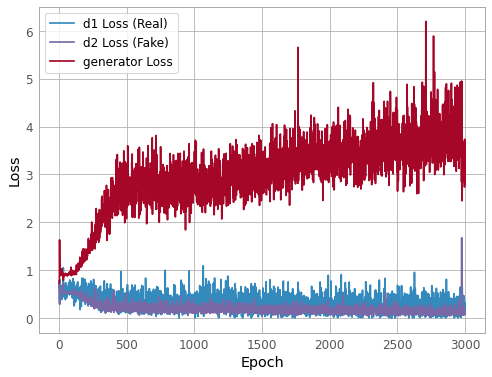

In [128]:
plt.plot(epochs, metrics[0], label = 'd1 Loss (Real)')
plt.plot(epochs, metrics[1], label = 'd2 Loss (Fake)')
plt.plot(epochs, metrics[2], label = 'generator Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('Loss_3type.png')
plt.show()

In [ ]:
nb_examples = 25

#Load pre-trained model
model = load_model('models_test/gan_generator_3000.h5')

#Generate images
latent_sample, labels = generate_latent_points(100, nb_examples)
#labels = np.asarray([x for _ in range(2) for x in range(2)])
labels = np.array([0 for _ in range (nb_examples)])

X = model.predict([latent_sample, labels])
X = (X + 1)/2.0
show_examples(X, labels, int(nb_examples**0.5), 'shell')
fig, ax = plt.subplots(2,2)
ax[0,0].imshow(np.log(.001 + X[0]), cmap = 'gray_r')
ax[0,0].set_title('Non-Tidal')
ax[0,1].imshow(np.log(.001 + X[1]), cmap = 'gray_r')
ax[0,1].set_title('Tidal')
ax[1,0].imshow(np.log(.001 + X[2]), cmap = 'gray_r')
ax[1,0].set_title('Non-Tidal')
ax[1,1].imshow(np.log(.001 + X[3]), cmap = 'gray_r')
ax[1,1].set_title('Tidal')
fig.set_figheight(15)
fig.set_figwidth(15)

In [19]:
storagePATH = '/media/miron/ec129152-c1e2-41c2-a7a2-54cc3884cb13/generated_data/'
from PIL import Image

def save_data(model, nb_samples, im_class):
    latent_sample, labels = generate_latent_points(100, nb_samples)
    labels = np.array([im_class for _ in range (nb_samples)])
    
    X = model.predict([latent_sample, labels])
    #[-1,1] to [0,1]
    X = (X + 1)/2.0
    
    if im_class == 0:
        np.save('generated_array/eval/no-aug_arm.npy', X)
    else:
        np.save('generated_array/eval/no-aug_shell.npy', X)
        

In [20]:
save_data(model, 1000, 0)
save_data(model, 1000, 1)